### 3.4 Shrinkage Methods
In this chapter we'll focus on shrinking our regression estimates. The advantage to shrinkage methods is often lower variance than model selection methods, which will yield better prediction error.

#### 3.4.1 Ridge Regression
We'll begin with the ridge regression, also commonly known as L2 regularization. Ridge regression shrinks the coefficients by imposing a penalty on their size. Similar to OLS, the ridge coefficients minimize a residual sum of squares, this time penalized by the shrinkage penalty.
$$
RSS(\lambda) = (y-X\beta)^T (y- X\beta) + \lambda \beta^T \beta
$$
Differentiating this and setting it equal to zero yields.
$$
\hat{\beta}^{ridge} = (X^T X + \lambda I)^{-1} X^T y
$$
Let us also introduce the singular value decomposition (SVD) of the centered input matrix X. This will be very useful in understanding ridge regression. The SVD has the form:
$$
X = UDV^{T}
$$

In [32]:
# Trying ridge class from scratch again.
# Import libraries.
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import math

# Read data.
data = pd.read_table('prostate.txt')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head(3)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T


In [33]:
# Grab train / test mask and target.
mask = data.pop('train')
y_ = data.pop('lpsa')

# Identify training set.
y_train = y_[mask == 'T']
X_train = data[mask == 'T']

# Normalize predictors with zscores.
X_train = X_train.apply(scipy.stats.zscore)

# Center target.
y_train_mean = y_train.mean()
y_train = y_train - y_train_mean

# Reset indexes.
y_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)

Before training our model, we need to discuss identification of the possible penalty hyperparameters. The hyperparameter $\lambda$ is constructed by considering the effective degrees of freedom for the ridge regression. These EDFs are given by the monotonically decreasing function $df\left(\lambda\right)$.
$$
df\left(\lambda\right) = \sum_{j=1}^{p} \frac{d_j^2}{d_j^2 + \lambda}
$$
Where $d_j$ are the entries of the diagonal matrix $D$ from the SVD of $X$. Note that the bounds of lambda are $\lambda \in \left[0, \infty \right)$, while the monotonically decreasing EDFs are bounded by $df\left(\lambda \right) \in \left[0, p \right]$ where $p$ is the number of predictors in our dataset. Notice that we only have a-priori knowledge of two things before further analysis. The set of EDFs, and the entries of the diagonal matrix $D$. Both of these are problem-dependent on the predictor data $X$.

From our EDFs and diagonal matrix entries, we can derive the set of shrinkage parameters $\lambda$. To find them, we'll utilize the Newton-Raphson method to find the roots of this real-valued function. First, define $h\left(\lambda\right)$.
$$
h\left(\lambda\right) = \sum_{i=1}^{n} \frac{d_i^2}{d_i^2 + \lambda} - df = 0
$$
Differentiating this yields.
$$
\frac{dh\left(\lambda\right)}{d\lambda} = - \sum_{i=1}^{n} \frac{d_i^2}{\left(d_i^2 + \lambda\right)^{2}}
$$
Then we have.
$$
h\left(\lambda\right) \approx h\left(\lambda_0\right) + \left( \lambda - \lambda_0 \right) \frac{dh\left(\lambda \right)}{d\lambda}\Bigg|_{\lambda = \lambda_0} = 0
$$
We can now solve this equation for lambda, which will show us how to approximate the roots. The final result is the following
$$
\lambda = \lambda_0 - \frac{h\left(\lambda_0\right)}{h'\left(\lambda_0 \right)}
$$
This method will be important in identifying the set of $\lambda$.

Ridge regression with K-fold cross validation class:

In [40]:
class ridge_reg:

    def __init__(self, X, y, K=10, inc=1, cross_valid=True):
        # Inputs.
        self.X = X      # Predictors for the regression.
        self.y = y      # Target for the regression.
        self.p = X.shape[1] # Predictors.

        # Settings
        self.K = K      # Number of folds to use in K-fold CV.
        self.inc = inc  # Increments for Newton-Raphson method.
        self.cross_valid = cross_valid  # Should we use cross validation.

        # Results.
        self.result = None


    # Convert result into dataframe.
    def result_df(self):
        temp_df = pd.DataFrame(self.result)
        temp_df = temp_df.explode(['edfs', 'rss'])

        temp_df['edfs'] = pd.to_numeric(temp_df['edfs'])
        temp_df['rss'] = pd.to_numeric(temp_df['rss'])

        eDFS = temp_df['edfs'].unique()
        cv_avgs = temp_df.groupby('edfs')['rss'].mean().reset_index(drop=True)

        result_df = pd.DataFrame({
            'edfs': eDFS, 'cv_err': cv_avgs
        })

        std_errs = self.get_std_errs(temp_df, result_df)

        result_df['cv_std_err'] = std_errs

        self.result = result_df


    # Make standard errors from CV_err sample mean.
    def get_std_errs(self, samples, avgs):
        storage_std_errs = []
        for i in range(self.p + 1):
            sample_mask = samples['edfs'] == i
            avgs_mask = avgs['edfs'] == i

            samples_ = samples[sample_mask]['rss']
            n = len(samples_)
            sample_avg = float(avgs[avgs_mask]['cv_err'][i])

            sample_std_dev = math.sqrt(sum((samples_ - sample_avg)**2) / (n-1))
            #std_err = sample_std_dev / math.sqrt(n)

            storage_std_errs.append(sample_std_dev)
        return storage_std_errs



    # Get CV error for edf = 0, the constant model.
    def const_model_result(self, folds):
        rss_, no_, edfs = [], np.nan, np.zeros(self.K)
        for i in range(self.K):
            fold_mask = folds != i
            fold_size = sum(fold_mask == True)

            y_train = self.y[fold_mask]
            y_train_avg = y_train.mean()

            rss = self.rss(y_train, y_train_avg, n=fold_size)
            rss_.append(rss)
        const_model = {'fold_no': no_, 'edfs': edfs, 'rss': rss_}
        return const_model


    # Newton-Raphson for getting EDFs and penalty hyperparameters.
    def newtons_method(self, X_train):
        dfs_no = self.p
        dfs = np.arange(self.inc, dfs_no + self.inc, self.inc)

        U, SIGMA, V = scipy.linalg.svd(X_train, full_matrices=False)
        d = SIGMA**2

        newt_thresh = 1e-3

        reg_params = []
        for df in dfs:
            param_j = 0
            param_j_next = 1e6

            difference = param_j_next - param_j
            while abs(difference) > newt_thresh:
                h_paramj = sum((d)/(d + param_j)) - df
                h_prime_paramj = sum((d)/((d + param_j)**2))
                param_j_next = param_j + (h_paramj) / (h_prime_paramj)
                difference = param_j_next - param_j
                param_j = param_j_next
            reg_params.append(param_j_next)

        return reg_params, dfs


    # Calculate ridge regression coefficient estimates.
    def get_betas(self, X, y, penalty):
        X, y = X.to_numpy(), y.to_numpy()
        I = np.identity(self.p)

        b = np.linalg.inv(X.T @ X + penalty * I) @ X.T @ y
        return b


    # Function to get predictions (y_hat)
    def predict(self, X, beta):
        X = X.to_numpy()
        return X @ beta


    # Function to get CV rss.
    def rss(self, y_tru, y_hat, n):
        return ((y_tru - y_hat)**2).sum() / n


    # Function to get K-folds of data.
    def K_folds(self):
        K, n = self.K, len(self.X)

        idxs_X = np.arange(n)
        idxs_fold = np.zeros(n)

        quo, remain = divmod(n, K)
        fold_size = [quo for _ in range(K)]
        for i in range(remain):
          fold_size[i] += 1

        for j, fold_size in enumerate(fold_size):
          curr_fold = np.random.choice(idxs_X, fold_size, replace=False)
          idxs_fold[curr_fold] = j

          idxs_X = sorted(list(set(idxs_X) - set(curr_fold)))

        return idxs_fold


    # Function to fit model, when we need to use cross-validation.
    def fit_with_cv(self):

        result = []

        K_fold_idxs = self.K_folds()

        const_models = self.const_model_result(K_fold_idxs)
        result.append(const_models)

        # Iterate through folds.
        for i in range(self.K):
            fold_mask = K_fold_idxs != i
            fold_size = sum(fold_mask == True)

            X_train = self.X[fold_mask]
            y_train = self.y[fold_mask]

            penalties, dfs = self.newtons_method(X_train)

            _edfs, _rss = [], []
            for penalty, df in zip(penalties, dfs):
                b = self.get_betas(X_train, y_train, penalty)
                y_hat = self.predict(X_train, b)
                rss = self.rss(y_train, y_hat, n=fold_size)
                _edfs.append(df)
                _rss.append(rss)
            fold_result = {
                'fold_no': i, 'edfs': _edfs, 'rss': _rss
            }
            result.append(fold_result)
        self.result = result
        self.result_df()

    
    # Fit without cross-validation, to examine estimators.
    def fit_no_cv(self):
        penalties, dfs = self.newtons_method(self.X)

        ridge_betas = []
        for l_ in penalties:
            betas = self.get_betas(self.X, self.y, l_)
            ridge_betas.append(betas)
        self.result = ridge_betas    

    # Main fit function.
    def fit(self):
        if self.cross_valid == True:
            self.fit_with_cv()
        elif self.cross_valid == False:
            self.fit_no_cv()

In [35]:
model = ridge_reg(X_train, y_train)
model.fit()

In [36]:
# Examine model results.
res = model.result
res

,edfs,cv_err,cv_std_err
0,0.0,1.434527,0.073851
1,1.0,0.975779,0.043820
2,2.0,0.741970,0.041083
3,3.0,0.616288,0.041017
4,4.0,0.542210,0.040805
5,5.0,0.494525,0.040220
6,6.0,0.462376,0.039401
7,7.0,0.442117,0.038711
8,8.0,0.434575,0.038468


In [37]:
# Find the best model.
best_mod_idx = res.cv_err.idxmin()
best_mask = res.index == best_mod_idx
res['best'] = np.where(best_mask, 1, 0)


# Find model within one standard deviation of the best model.
res['within_one'] = (res['cv_err'] + res['cv_std_err'])
res['within_'] = np.where(res.cv_err <= res.within_one[best_mod_idx], 1, 0)

optimal_model_idx = res['within_'].idxmax()
optimal_mask = res.index == optimal_model_idx

# Coordinates for plotting.
y_coord = res[best_mask].within_one
x_coord = res[optimal_mask].edfs


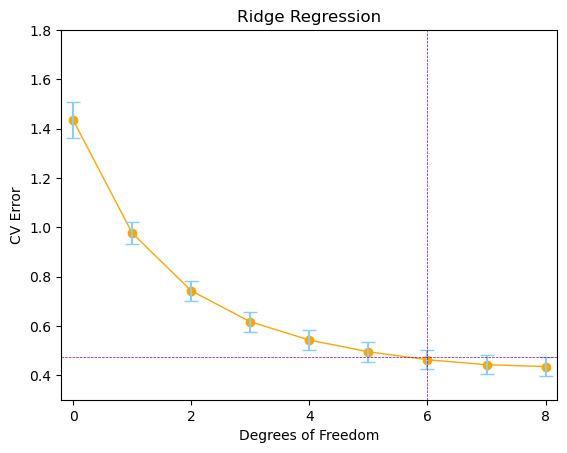

In [38]:
plt.plot(res['edfs'], res['cv_err'], 'o-', color='orange', lw=1)
plt.errorbar(res['edfs'], res['cv_err'], yerr=res['cv_std_err'], ecolor='lightskyblue', ls='None', capsize=5)

plt.xlim(-.2, 8.2)
plt.xticks([0, 2, 4, 6, 8])
plt.ylim(0.3, 1.8)

plt.plot([-.2, 8.2], [y_coord, y_coord], '--', color='purple', lw=0.5)
plt.plot([x_coord, x_coord],[0.3,1.8], '--', color='purple', lw=0.5)


plt.title("Ridge Regression")
plt.xlabel('Degrees of Freedom')
plt.ylabel('CV Error')

plt.show()

Now that we've identified the best model, let's examine the change in predictor coefficients as our penalty parameter changes. This time we'll examine the predictors using the entire training set, without K-fold cross validation.

In [106]:
model_2 = ridge_reg(X_train, y_train, inc=0.5, cross_valid=False)
model_2.fit()
ridge_betas = model_2.result

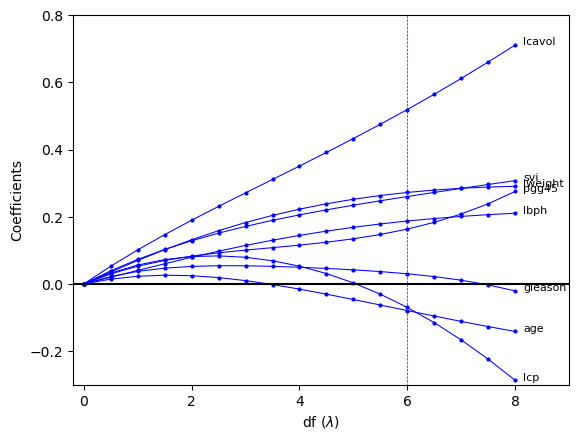

In [107]:
const_model = np.zeros(8)
ridge_betas.insert(0, const_model)

dfs = np.arange(0, X_train.shape[1] + 0.5, 0.5)

plt.plot(dfs, ridge_betas, 'o-',markersize=2, c='blue', lw=0.75)

plt.ylabel('Coefficients')
plt.xlabel('df ($\lambda$)')

plt.hlines(y=0, xmin=-0.2, xmax=9, colors='black')
plt.plot([x_coord, x_coord],[-1,1], '--', color='purple', lw=0.5)

plt.xlim([-0.2, 9])
plt.ylim([-0.3, 0.8])

for x, y, s in zip(np.ones(8)*(8+0.15), ridge_betas[-1], X_train.columns):
    plt.text(x, y, s, color='0', fontsize=8)
plt.show()